     word        coef
0      셔츠  122.119917
1      니트  116.633403
2      반팔  103.171449
3      여성   96.230924
4     가디건   72.900372
5     원피스   70.373330
6     카라티   55.723497
7     케이블   54.890308
8   스트라이프   52.953906
9     새상품   45.822737
10     정품   45.047257
11    화이트   43.589761
12     xs   41.562713
13    티셔츠   40.341764
14     린넨   35.316467
15    꽈배기   34.989745
16    네이비   34.879175
17    빅포니   33.658285
18    브이넥   30.321970
19     핑크   30.088533
20     자켓   30.054866
21    반팔티   28.946587
22    보이즈   26.128059
23   후드집업   25.912265
24     여자   24.954338
25     우먼   24.637717
26     xl   23.718530
27   반팔니트   22.944076
28     카라   22.929847
29     코튼   22.004303


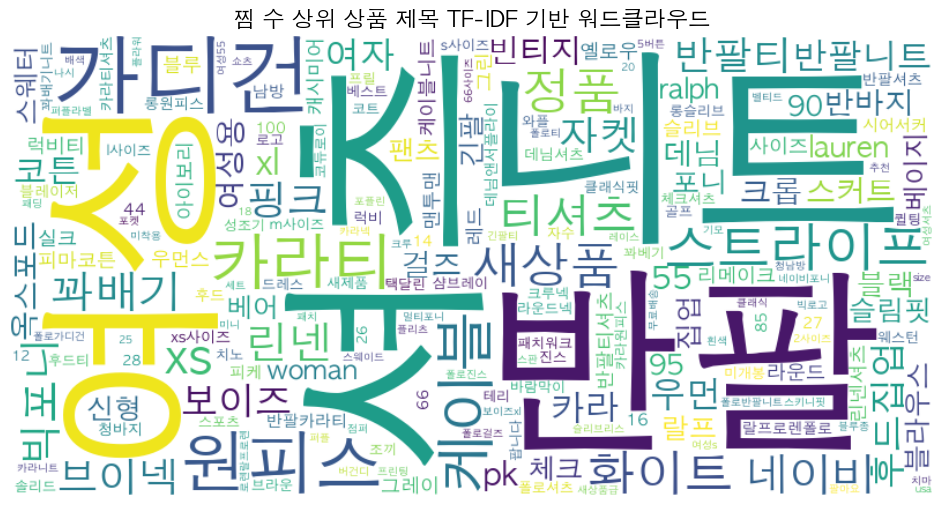

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

# CSV 파일 로드
df = pd.read_csv('전처리 최종파일.csv')

polo_df = df[df['brand_name'].str.contains('폴로', case=False, na=False)]

# 찜 수 기준 상위 20% 상품만 선택
likes_80th = polo_df['likes'].quantile(0.80)
top_df = polo_df[polo_df['likes'] >= likes_80th]

# 상품명 리스트 추출 (결측치 제거 후 문자열로 변환)
documents = top_df['name'].dropna().astype(str).tolist()

# 사용자 지정 불용어 리스트
custom_stopwords = ['폴로', 'polo', '랄프로렌', '폴로랄프로렌', '로렌']

# TF-IDF 벡터라이저 설정 (불용어 제거 포함)
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words=custom_stopwords
)

# TF-IDF 계산
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()
tfidf_sum = tfidf_matrix.sum(axis=0).A1
tfidf_dict = dict(zip(feature_names, tfidf_sum))

# TF-IDF 높은 순으로 정렬해서 DataFrame 생성
tfidf_df = pd.DataFrame({
    'word': feature_names,
    'coef': tfidf_sum
}).sort_values(by='coef', ascending=False).reset_index(drop=True)

# 상위 키워드 출력
print(tfidf_df.head(30))

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(tfidf_dict)

# 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("찜 수 상위 상품 제목 TF-IDF 기반 워드클라우드", fontsize=16)
plt.show()

In [11]:
from scipy.stats import ttest_ind

def hypothesis_test(df, col, group_col='is_representative'):
    group1 = df[df[group_col] == True][col].dropna()
    group2 = df[df[group_col] == False][col].dropna()

    stat, p = ttest_ind(group1, group2, equal_var=False)
    print(f"\n '{col}'에 대한 독립표본 t-검정 결과:")
    print(f"  - 대표상품 평균: {group1.mean():.4f}")
    print(f"  - 기타상품 평균: {group2.mean():.4f}")
    print(f"  - t-statistic: {stat:.4f}, p-value: {p:.4f}")
    
    if p < 0.05:
        print("  ✅ 통계적으로 유의미한 차이가 있습니다 (p < 0.05)")
    else:
        print("  ❌ 통계적으로 유의미한 차이가 없습니다 (p ≥ 0.05)")


 [폴로] 키워드 ['가디건'] 포함 여부별 샘플 수:
is_representative
기타      7072
대표상품     489
Name: count, dtype: int64

 [폴로] - 대표상품 여부에 따른 평균
                        views     likes
is_representative                      
기타                  65.030119  3.062500
대표상품               133.449898  6.883436

 로그 변환 평균 (log1p)
                   log_views  log_likes
is_representative                      
기타                  3.139633   0.734969
대표상품                3.611765   1.091638

 반응도 평균 (likes / views)
                   act_ratio
is_representative           
기타                  0.044993
대표상품                0.051180


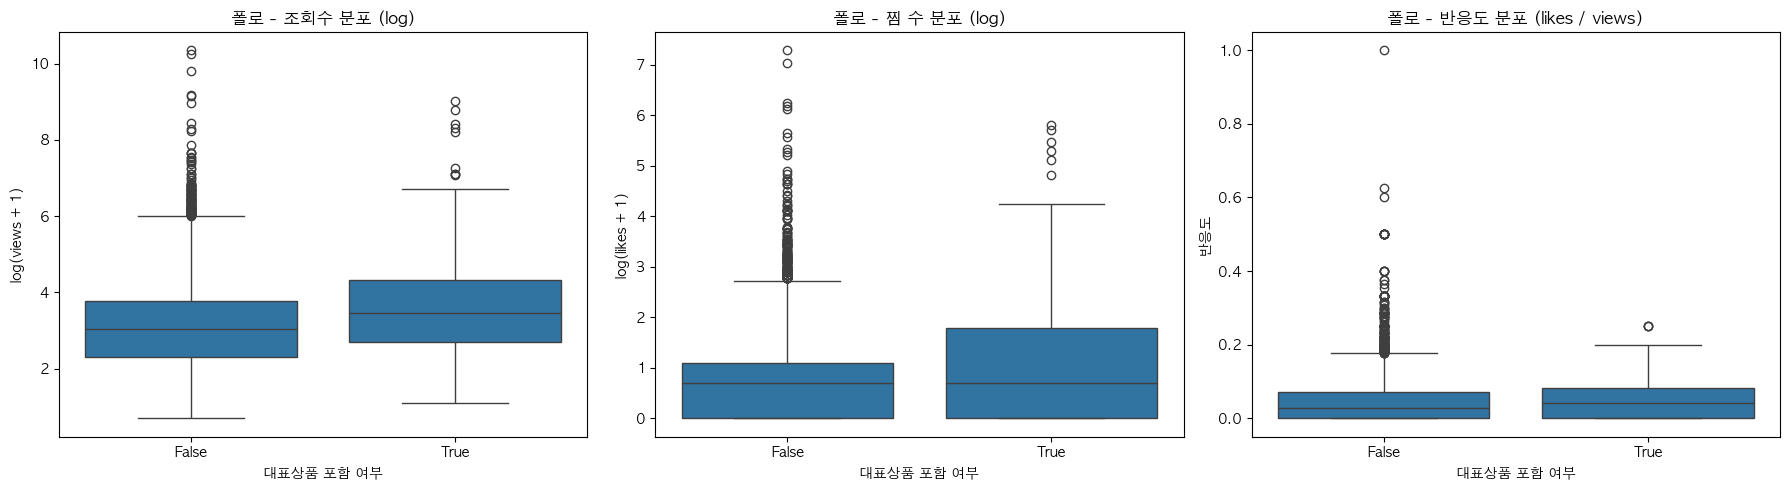


 'log_views'에 대한 독립표본 t-검정 결과:
  - 대표상품 평균: 3.6118
  - 기타상품 평균: 3.1396
  - t-statistic: 8.0738, p-value: 0.0000
  ✅ 통계적으로 유의미한 차이가 있습니다 (p < 0.05)

 'log_likes'에 대한 독립표본 t-검정 결과:
  - 대표상품 평균: 1.0916
  - 기타상품 평균: 0.7350
  - t-statistic: 7.0240, p-value: 0.0000
  ✅ 통계적으로 유의미한 차이가 있습니다 (p < 0.05)

 'act_ratio'에 대한 독립표본 t-검정 결과:
  - 대표상품 평균: 0.0512
  - 기타상품 평균: 0.0450
  - t-statistic: 2.5436, p-value: 0.0112
  ✅ 통계적으로 유의미한 차이가 있습니다 (p < 0.05)


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def analyze_representative_product(df, brand, keyword_list, name_col='name'):

    # 1. 브랜드 필터링
    brand_df = df[df['brand_name'] == brand].copy()

    # 2. 여러 키워드 OR 결합 (정규표현식으로)
    pattern = '|'.join(keyword_list)
    brand_df['is_representative'] = brand_df[name_col].str.contains(pattern, case=False, na=False)

    # 3. 로그 변환 컬럼 생성
    brand_df['log_views'] = np.log1p(brand_df['views'])
    brand_df['log_likes'] = np.log1p(brand_df['likes'])

    # 4. 반응도 컬럼 추가
    brand_df['act_ratio'] = brand_df['likes'] / brand_df['views'].replace(0, np.nan)

    # 5. 그룹별 샘플 수 출력
    print(f"\n [{brand}] 키워드 {keyword_list} 포함 여부별 샘플 수:")
    print(brand_df['is_representative'].value_counts().rename(index={True: '대표상품', False: '기타'}))

    # 6. 평균 출력
    mean_df = brand_df.groupby('is_representative')[
        ['views', 'likes', 'log_views', 'log_likes', 'act_ratio']
    ].mean().rename(index={True: '대표상품', False: '기타'})

    print(f"\n [{brand}] - 대표상품 여부에 따른 평균")
    print(mean_df[['views', 'likes']])
    print(f"\n 로그 변환 평균 (log1p)")
    print(mean_df[['log_views', 'log_likes']])
    print(f"\n 반응도 평균 (likes / views)")
    print(mean_df[['act_ratio']])

    # 7. 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.boxplot(x='is_representative', y='log_views', data=brand_df, ax=axes[0])
    axes[0].set_title(f"{brand} - 조회수 분포 (log)")
    axes[0].set_xlabel("대표상품 포함 여부")
    axes[0].set_ylabel("log(views + 1)")

    sns.boxplot(x='is_representative', y='log_likes', data=brand_df, ax=axes[1])
    axes[1].set_title(f"{brand} - 찜 수 분포 (log)")
    axes[1].set_xlabel("대표상품 포함 여부")
    axes[1].set_ylabel("log(likes + 1)")

    sns.boxplot(x='is_representative', y='act_ratio', data=brand_df, ax=axes[2])
    axes[2].set_title(f"{brand} - 반응도 분포 (likes / views)")
    axes[2].set_xlabel("대표상품 포함 여부")
    axes[2].set_ylabel("반응도")

    plt.tight_layout()
    plt.show()

analyze_representative_product(df, brand='폴로', keyword_list=['가디건'])

##############################################################
brand_df = df[df['brand_name'] == '폴로'].copy()
pattern = '|'.join(['가디건'])
brand_df['is_representative'] = brand_df['name'].str.contains(pattern, case=False, na=False)
brand_df['log_views'] = np.log1p(brand_df['views'])
brand_df['log_likes'] = np.log1p(brand_df['likes'])
brand_df['act_ratio'] = brand_df['likes'] / brand_df['views'].replace(0, np.nan)

hypothesis_test(brand_df, 'log_views')
hypothesis_test(brand_df, 'log_likes')
hypothesis_test(brand_df, 'act_ratio')